In this notebook we learn about Deep Partition Aggregation (DPA), a certified defense against a general poisoning 
threat model. In this defense mechanism we either do an insertion or deletion of a bounded number of samples to the 
training set by implication. This threat model further applies a random number of distortions to a bounded
number of images and/or labels. Here the subset aggreagtion is obtained through ensemble ML as well as this method relies on randomized smoothing.

# Deep Partition Aggregation

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.get_logger().setLevel('ERROR')

from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor, PoisoningAttackCleanLabelBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd
from art.utils import load_mnist, preprocess, to_categorical
from art.defences.trainer import AdversarialTrainerMadryPGD


from art.estimators.classification.deep_partition_ensemble import DeepPartitionEnsemble

# Load the Data

In [2]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

# Random Selection:
n_train = np.shape(x_raw)[0]
num_selection = 10000
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

# Poison training data
percent_poison = .33
x_train, y_train = preprocess(x_raw, y_raw)
x_train = np.expand_dims(x_train, axis=3)

x_test, y_test = preprocess(x_raw_test, y_raw_test)
x_test = np.expand_dims(x_test, axis=3)

# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

# Initialize the Model Architecture

In [3]:
# Create Keras convolutional neural network - basic architecture from Keras examples
# Source here: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
def create_model():    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Set up the Model Backdoor

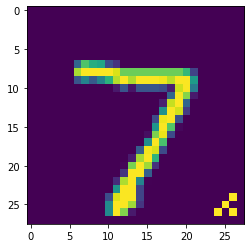

In [4]:
backdoor = PoisoningAttackBackdoor(add_pattern_bd)
example_target = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
pdata, plabels = backdoor.poison(x_test, y=example_target)

plt.imshow(pdata[0].squeeze())

# Create the poison data
For this example, we will select 9 as the target class. Thus, the adversary's goal is to poison the model so adding a trigger will result in the trained model misclassifying the triggered input as a 9.

First, the adversary will create a proxy classifier (i.e., a classifier that is similar to the target classifier). As the clean label attack generates noise using PGD in order to encourage the trained classifier to rely on the trigger, it is important that the generated noise be transferable. Thus, adversarial training is used.

In [5]:
# Poison some percentage of all non-nines to nines
targets = to_categorical([9], 10)[0] 

proxy = AdversarialTrainerMadryPGD(KerasClassifier(create_model()), nb_epochs=10, eps=0.15, eps_step=0.001)
proxy.fit(x_train, y_train)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

In [6]:
attack = PoisoningAttackCleanLabelBackdoor(backdoor=backdoor, proxy_classifier=proxy.get_classifier(),
                                           target=targets, pp_poison=percent_poison, norm=2, eps=5,
                                           eps_step=0.1, max_iter=200)
pdata, plabels = attack.poison(x_train, y_train)

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

In [7]:
poisoned = pdata[np.all(plabels == targets, axis=1)]
poisoned_labels = plabels[np.all(plabels == targets, axis=1)]
print(len(poisoned))
for i in range(len(poisoned)):
    if poisoned[i][0][0] != 0:
        plt.imshow(poisoned[i].squeeze())
        plt.show()
        print(f"Index: {i} Label: {np.argmax(poisoned_labels[i])}")
        break

1020


# Initialize the classification models
We will initialize four models. The first is a single model architecture. The other three are DPA models with varying ensemble sizes to demonstrate the tradeoff between clean accuracy and poison accuracy. This make take some time because of the model copying.

In [8]:
model = KerasClassifier(create_model())
dpa_model_10 = DeepPartitionEnsemble(model, ensemble_size=10)
dpa_model_20 = DeepPartitionEnsemble(model, ensemble_size=20)
dpa_model_30 = DeepPartitionEnsemble(model, ensemble_size=30)


Train the models on the poisoned data

In [9]:
model.fit(pdata, plabels, nb_epochs=10)
dpa_model_10.fit(pdata, plabels, nb_epochs=10)
dpa_model_20.fit(pdata, plabels, nb_epochs=10)
dpa_model_30.fit(pdata, plabels, nb_epochs=10)

Train on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 9s 901us/sample - loss: 0.6975 - accuracy: 0.7831
Epoch 2/10
10000/10000 [==============================] - 8s 808us/sample - loss: 0.2377 - accuracy: 0.9326
Epoch 3/10
10000/10000 [==============================] - 7s 746us/sample - loss: 0.1533 - accuracy: 0.9562
Epoch 4/10
10000/10000 [==============================] - 8s 849us/sample - loss: 0.1103 - accuracy: 0.9690
Epoch 5/10
10000/10000 [==============================] - 8s 822us/sample - loss: 0.0774 - accuracy: 0.9755 - loss: 0.078
Epoch 6/10
10000/10000 [==============================] - 8s 796us/sample - loss: 0.0713 - accuracy: 0.9783
Epoch 7/10
10000/10000 [==============================] - 8s 787us/sample - loss: 0.0625 - accuracy: 0.9804
Epoch 8/10
10000/10000 [==============================] - 8s 832us/sample - loss: 0.0504 - accuracy: 0.9833
Epoch 9/10
10000/10000 [==============================] - 8s 768us/sample - loss: 0.0423 - accuracy

498/498 [==============================] - 0s 834us/sample - loss: 0.9045 - accuracy: 0.7008
Epoch 5/10
498/498 [==============================] - 0s 798us/sample - loss: 0.7485 - accuracy: 0.7329
Epoch 6/10
498/498 [==============================] - 0s 937us/sample - loss: 0.6128 - accuracy: 0.8133
Epoch 7/10
498/498 [==============================] - 0s 951us/sample - loss: 0.5249 - accuracy: 0.8193
Epoch 8/10
498/498 [==============================] - 0s 751us/sample - loss: 0.4706 - accuracy: 0.8635
Epoch 9/10
498/498 [==============================] - 0s 759us/sample - loss: 0.4028 - accuracy: 0.8855
Epoch 10/10
498/498 [==============================] - 0s 881us/sample - loss: 0.3286 - accuracy: 0.9016
Train on 473 samples
Epoch 1/10
473/473 [==============================] - 1s 2ms/sample - loss: 2.1727 - accuracy: 0.2748
Epoch 2/10
473/473 [==============================] - 0s 797us/sample - loss: 1.5747 - accuracy: 0.5772
Epoch 3/10
473/473 [==============================] - 0

489/489 [==============================] - 0s 822us/sample - loss: 0.3409 - accuracy: 0.8793
Epoch 9/10
489/489 [==============================] - 0s 794us/sample - loss: 0.3326 - accuracy: 0.8937
Epoch 10/10
489/489 [==============================] - 0s 775us/sample - loss: 0.3156 - accuracy: 0.8937
Train on 316 samples
Epoch 1/10
316/316 [==============================] - 1s 2ms/sample - loss: 2.2409 - accuracy: 0.1804
Epoch 2/10
316/316 [==============================] - 0s 802us/sample - loss: 1.8369 - accuracy: 0.5000
Epoch 3/10
316/316 [==============================] - 0s 820us/sample - loss: 1.3482 - accuracy: 0.5886
Epoch 4/10
316/316 [==============================] - 0s 838us/sample - loss: 1.0425 - accuracy: 0.6487
Epoch 5/10
316/316 [==============================] - 0s 810us/sample - loss: 0.8269 - accuracy: 0.7215
Epoch 6/10
316/316 [==============================] - 0s 834us/sample - loss: 0.6793 - accuracy: 0.7722
Epoch 7/10
316/316 [==============================] - 0

317/317 [==============================] - 0s 776us/sample - loss: 1.8295 - accuracy: 0.4637
Epoch 3/10
317/317 [==============================] - 0s 791us/sample - loss: 1.3331 - accuracy: 0.6151
Epoch 4/10
317/317 [==============================] - 0s 785us/sample - loss: 0.9961 - accuracy: 0.6593
Epoch 5/10
317/317 [==============================] - 0s 763us/sample - loss: 0.8076 - accuracy: 0.7098
Epoch 6/10
317/317 [==============================] - 0s 768us/sample - loss: 0.6023 - accuracy: 0.7886
Epoch 7/10
317/317 [==============================] - 0s 749us/sample - loss: 0.5319 - accuracy: 0.7981
Epoch 8/10
317/317 [==============================] - 0s 751us/sample - loss: 0.4819 - accuracy: 0.8328
Epoch 9/10
317/317 [==============================] - 0s 769us/sample - loss: 0.3801 - accuracy: 0.8770
Epoch 10/10
317/317 [==============================] - 0s 750us/sample - loss: 0.3541 - accuracy: 0.8833
Train on 311 samples
Epoch 1/10
311/311 [==============================] -

# Evaluate the performance of the trained models on unpoisoned data
The performance of the models appears normal. We see that for the DPA models, the performance drops slightly as the ensemble size increases


Clean test set accuracy (model): 98.12%


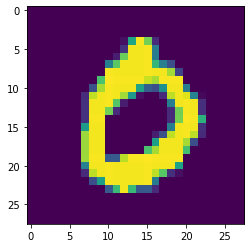

Prediction: 0


In [10]:
clean_preds = np.argmax(model.predict(x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(y_test, axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy (model): %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(y_test, 1) == c)[0][i] # index of the image in clean arrays

plt.imshow(x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))


Clean test set accuracy (DPA model_10): 93.98%


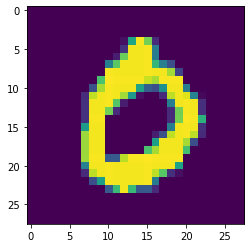

Prediction: 0


In [11]:
clean_preds = np.argmax(dpa_model_10.predict(x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(y_test, axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy (DPA model_10): %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(y_test, 1) == c)[0][i] # index of the image in clean arrays

plt.imshow(x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))


Clean test set accuracy (DPA model_20): 90.98%


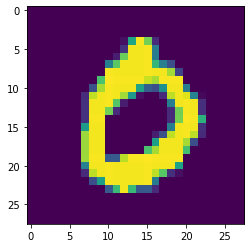

Prediction: 0


In [12]:
clean_preds = np.argmax(dpa_model_20.predict(x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(y_test, axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy (DPA model_20): %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(y_test, 1) == c)[0][i] # index of the image in clean arrays

plt.imshow(x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))


Clean test set accuracy (DPA model_30): 89.54%


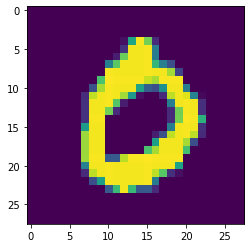

Prediction: 0


In [13]:
clean_preds = np.argmax(dpa_model_30.predict(x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(y_test, axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy (DPA model_30): %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(y_test, 1) == c)[0][i] # index of the image in clean arrays

plt.imshow(x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))

# Evaluate the performance of the trained models on poisoned data
When the trigger is added, we see a shift in performance. The single model performs the worst as no defense is in place to mitigate the effect of the poisoned. The DPA models show some robustnesss to the poison as they partition the training data, which spreads the effect of the poison between models in the ensemble.


Poison test set accuracy (model): 0.00%


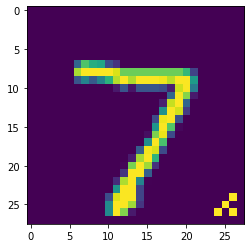

Prediction: 9


In [14]:
not_target = np.logical_not(np.all(y_test == targets, axis=1))
px_test, py_test = backdoor.poison(x_test[not_target], y_test[not_target])

poison_preds = np.argmax(model.predict(px_test), axis=1)
clean_correct = np.sum(poison_preds == np.argmax(y_test[not_target], axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nPoison test set accuracy (model): %.2f%%" % (clean_acc * 100))

c = 0 # index to display
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(poison_preds[c]))


Poison test set accuracy (DPA model_10): 59.01%


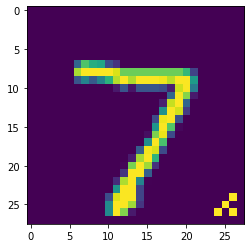

Prediction: 7


In [15]:
poison_preds = np.argmax(dpa_model_10.predict(px_test), axis=1)
clean_correct = np.sum(poison_preds == np.argmax(y_test[not_target], axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nPoison test set accuracy (DPA model_10): %.2f%%" % (clean_acc * 100))

c = 0 # index to display
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(poison_preds[c]))


Poison test set accuracy (DPA model_20): 68.60%


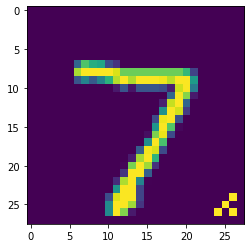

Prediction: 7


In [16]:
poison_preds = np.argmax(dpa_model_20.predict(px_test), axis=1)
clean_correct = np.sum(poison_preds == np.argmax(y_test[not_target], axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nPoison test set accuracy (DPA model_20): %.2f%%" % (clean_acc * 100))

c = 0 # index to display
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(poison_preds[c]))


Poison test set accuracy (DPA model_30): 70.40%


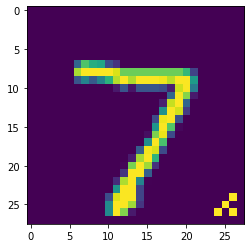

Prediction: 7


In [17]:
poison_preds = np.argmax(dpa_model_30.predict(px_test), axis=1)
clean_correct = np.sum(poison_preds == np.argmax(y_test[not_target], axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nPoison test set accuracy (DPA model_30): %.2f%%" % (clean_acc * 100))

c = 0 # index to display
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(poison_preds[c]))